# **📊 Basic Analysis of 2022**

In this notebook, we perform some basic analysis of the 2022 dataset, processed in [📓 this notebook](../preprocessing/preprocessing_pipeline.ipynb).

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
transport_data = pd.read_parquet("../../data/processed/transports.parquet")
transport_data.head()

,trip_id,product_id,line_text,transport_type,stop_id,arrival_time,departure_time,mean_arrival_delay,mean_departure_delay,median_arrival_delay,median_departure_delay,std_arrival_delay,std_departure_delay,n_arrival_delay,n_departure_delay,n_cancelled,n_through_trip,n_additional_trip,n_entries
0,80:06____:17171:000,Train,RB,RB,8500090,14:50:00,None,293.939394,NaN,120.0,NaN,388.229414,NaN,68,0,4,0,0,104
1,80:06____:17261:000,Train,RB,RB,8500090,None,15:53:00,NaN,61.621622,NaN,0.0,NaN,129.218022,0,9,1,0,0,104
2,80:800693:3053:000,Train,IRE3,IRE,8503424,11:58:00,12:00:00,151.539474,127.605263,41.0,19.0,627.797068,622.499501,60,73,2,0,0,78
3,80:80____:2887:000,Train,ICE,ICE,8500090,22:46:00,None,1080.000000,NaN,1080.0,NaN,NaN,NaN,1,0,0,0,1,1
4,80:sbg034:14004,Bus,Bus7349,B,8573327,09:07:00,None,2.400000,NaN,0.0,NaN,29.443320,NaN,5,0,0,0,0,100


In [3]:
transport_data.shape[0]

65804937

## **🛡️ Check Integrity of Features**

Before analysis, we will check the integrity of features, and modify them if necessary. These changes will be saved as a new _v2_ dataset

### **1️⃣ product_id**

In [4]:
transport_data['product_id'].unique()

array(['Train', 'Bus', 'Rack_railway', 'Metro', 'Boat', 'Tram',
       'Stadtbahn', 'Standseilbahn', 'WM-Bus'], dtype=object)

In [5]:
print(f"There are {transport_data[transport_data['product_id'] == 'Stadtbahn'].shape[0]} Stadtbahn transports.")
print(f"There are {transport_data[transport_data['product_id'] == 'Standseilbahn'].shape[0]} Standseilbahn transports.")
print(f"There are {transport_data[transport_data['product_id'] == 'WM-Bus'].shape[0]} S-Bahn transports.")

There are 6800 Stadtbahn transports.
There are 170 Standseilbahn transports.
There are 4 S-Bahn transports.


In [6]:
# Replace Stadtbahn by Train
transport_data['product_id'] = transport_data['product_id'].replace('Stadtbahn', 'Train')

# Replace Standseilbahn by Rack Railway
transport_data['product_id'] = transport_data['product_id'].replace('Rack_railway', 'Rack Railway')
transport_data['product_id'] = transport_data['product_id'].replace('Standseilbahn', 'Rack Railway')

# Replace WM-Bus by Bus
transport_data['product_id'] = transport_data['product_id'].replace('WM-Bus', 'Bus')

In [7]:
transport_data['product_id'].unique()

array(['Train', 'Bus', 'Rack Railway', 'Metro', 'Boat', 'Tram'],
      dtype=object)

### **2️⃣ transport_type**

- _**BUS** (`Bus`): Bus service._
- **NB** (`Bus`): Bus service.
- **AG** (`Train`): Train service.
- **ATZ** (`Train`): Train service.
- **EN** (`Train`): Train service.
- **EV** (`Bus`): Bus service.
- **RJ** (`RailJet`): High-speed train service connecting Austria with several neighboring countries, including Switzerland.
- _**ZUG** (`Zug`): Train service._

In [8]:
set(transport_data['transport_type'].unique()).difference(set(['RB', 'IRE', 'RE', 'ICE', 'FLX', 'S', 'B', 'R', 'IC', 'EC', 'IR', 'RJX', 'TER', 'EXT', 'NJ', 'TGV', 'CC', 'M', 'BAT', 'PE', 'T', 'CAR', 'EXB', 'Z']))

{'AG', 'ATZ', 'BUS', 'EN', 'EV', 'FUN', 'MAT', 'NB', 'RJ', 'ZUG'}

In [9]:
# Merge BUS, NB and B
transport_data['transport_type'] = transport_data['transport_type'].replace('BUS', 'B')

In [10]:
# Merge ZUG and Z
transport_data['transport_type'] = transport_data['transport_type'].replace('ZUG', 'Z')

In [11]:
# Delete MAT, since it only has 1 entry
transport_data = transport_data[transport_data['transport_type'] != 'MAT']

### **3️⃣ n_entries**

In [12]:
MIN_N_ENTRIES = 25
transport_data = transport_data[transport_data['n_entries'] >= MIN_N_ENTRIES]

In [13]:
transport_data.shape[0]

5527916

In [14]:
# Save the data
transport_data['n_arrival_delay'] = transport_data['n_arrival_delay'].astype('int32')
transport_data['n_arrival_delay'] = transport_data['n_arrival_delay'].astype('int32')
transport_data['n_departure_delay'] = transport_data['n_departure_delay'].astype('int32')
transport_data['n_cancelled'] = transport_data['n_cancelled'].astype('int32')
transport_data['n_through_trip'] = transport_data['n_through_trip'].astype('int32')
transport_data['n_additional_trip'] = transport_data['n_additional_trip'].astype('int32')
transport_data['n_entries'] = transport_data['n_entries'].astype('int32')

TRANSPORT_DATA_V2_PATH = "../../data/processed/transports_v2.parquet"
transport_data.to_parquet(TRANSPORT_DATA_V2_PATH)

## **📊 Histograms of Features**

In [15]:
N_COLORS = 6
palette = sns.color_palette('colorblind', n_colors=N_COLORS)
palette

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451)]

In [16]:
product_to_color = dict(zip(['Bus', 'Train', 'Tram', 'Metro', 'Rack Railway', 'Boat'], palette))

### **🛬 Arrival Delays**

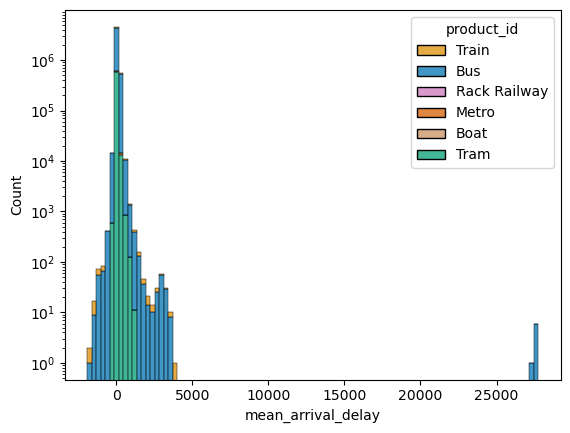

In [17]:
sns.histplot(transport_data, x="mean_arrival_delay", hue="product_id", multiple="stack", palette=product_to_color, bins=100)
plt.yscale('log')
plt.show()

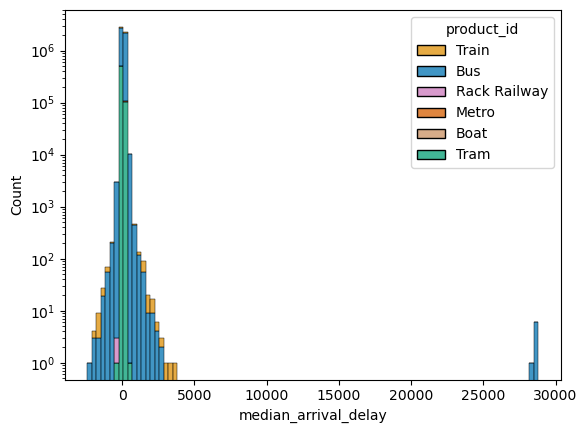

In [18]:
sns.histplot(transport_data, x="median_arrival_delay", hue="product_id", multiple="stack", palette=product_to_color, bins=100)
plt.yscale('log')
plt.show()

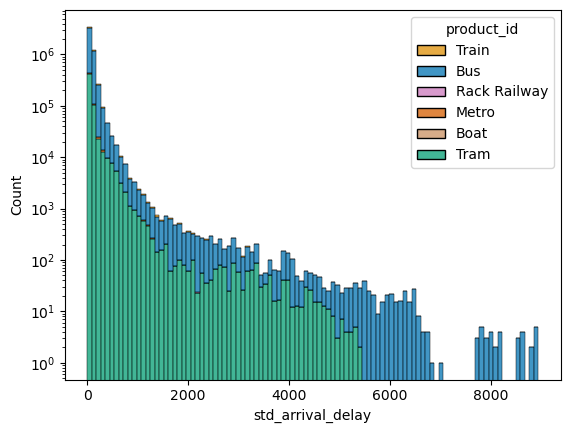

In [19]:
sns.histplot(transport_data, x="std_arrival_delay", hue="product_id", multiple="stack", palette=product_to_color, bins=100)
plt.yscale('log')
plt.show()

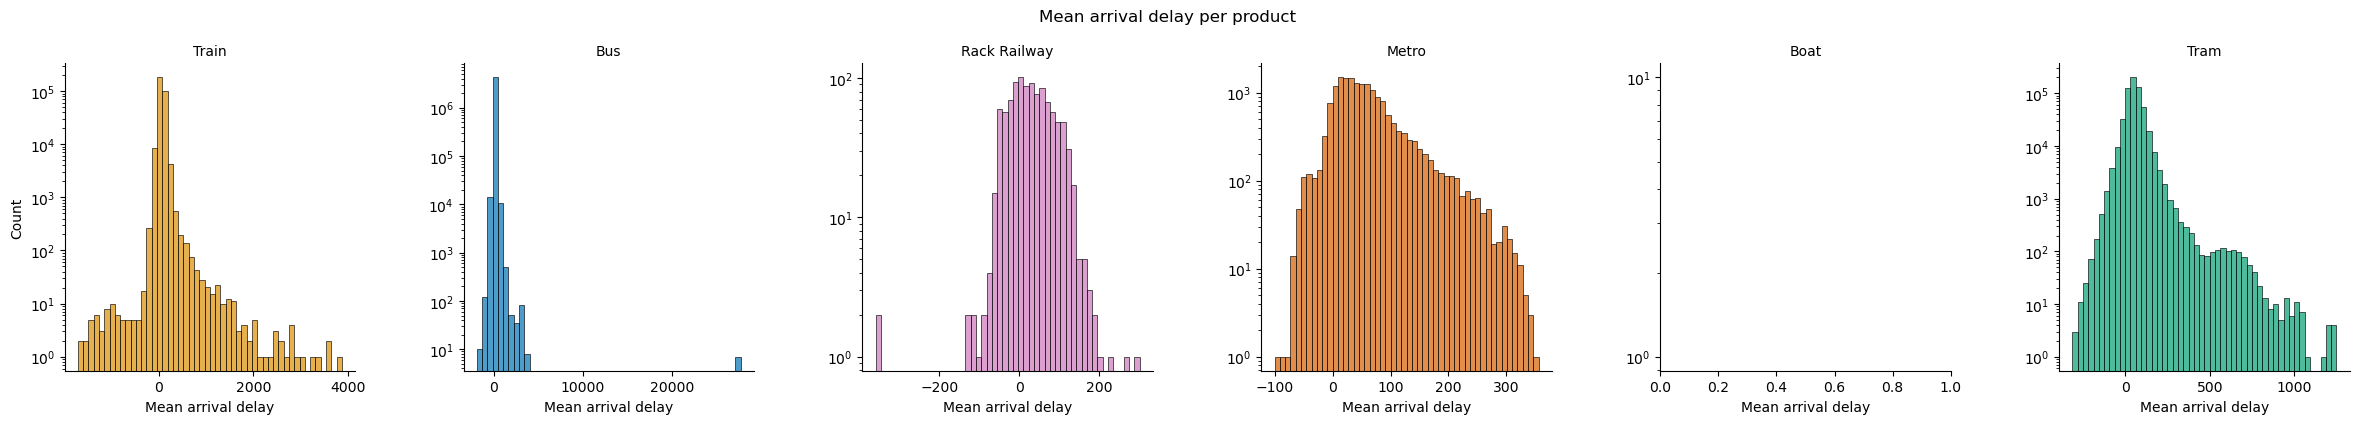

In [20]:
unique_product_ids = transport_data['product_id'].unique()

g = sns.FacetGrid(
    transport_data, 
    col="product_id",
    col_wrap=len(unique_product_ids), 
    hue='product_id', 
    palette=product_to_color,
    height=4, 
    aspect=1,
    sharey=False,
    sharex=False,
)
# Map the histplot function to each subplot
g.map(sns.histplot, "mean_arrival_delay", bins=50, alpha=0.7)
g.set(yscale="log")

# Set the titles and labels
g.set_titles("{col_name}")
g.set_axis_labels("Mean arrival delay", "Count")
g.fig.suptitle("Mean arrival delay per product", y=1.05)

# Show the plot
plt.show()

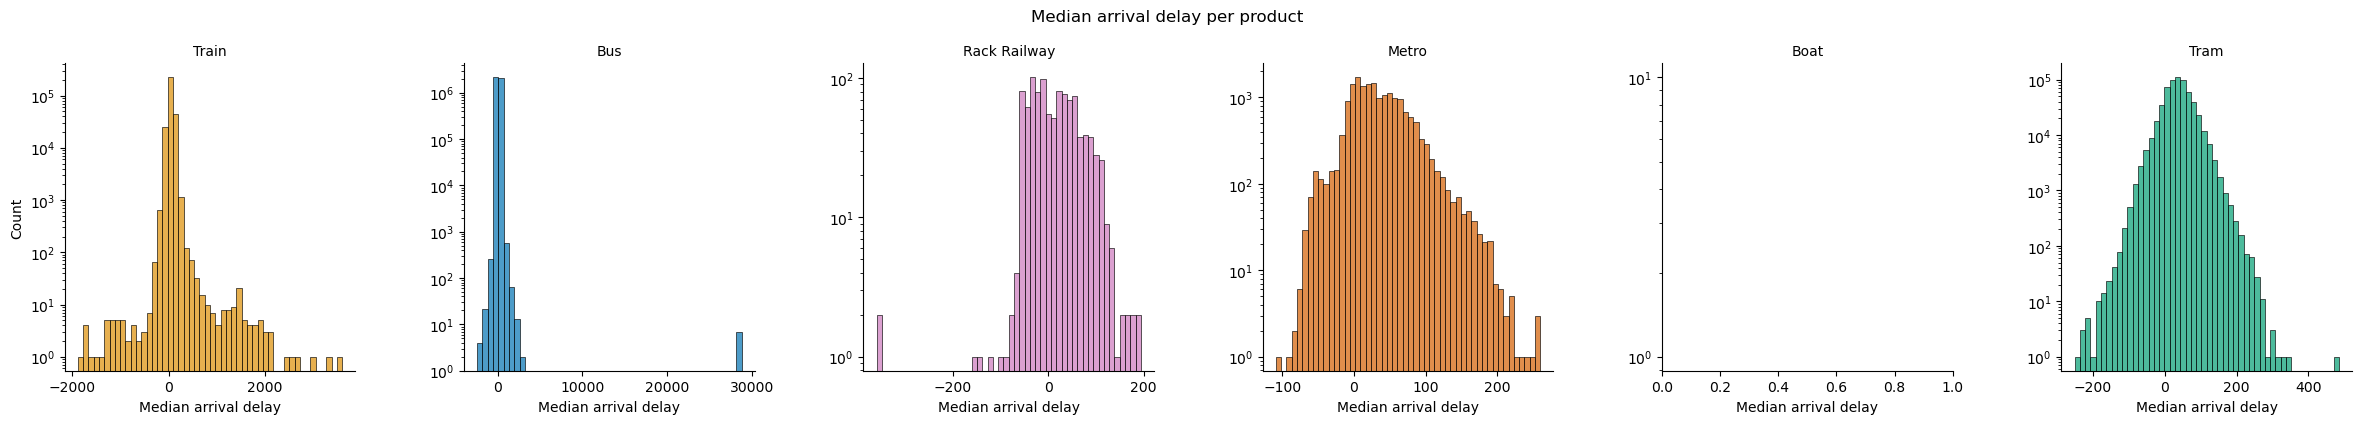

In [21]:
unique_product_ids = transport_data['product_id'].unique()

g = sns.FacetGrid(
    transport_data, 
    col="product_id",
    col_wrap=len(unique_product_ids), 
    hue='product_id', 
    palette=product_to_color,
    height=4, 
    aspect=1,
    sharey=False,
    sharex=False,
)
# Map the histplot function to each subplot
g.map(sns.histplot, "median_arrival_delay", bins=50, alpha=0.7)
g.set(yscale="log")

# Set the titles and labels
g.set_titles("{col_name}")
g.set_axis_labels("Median arrival delay", "Count")
g.fig.suptitle("Median arrival delay per product", y=1.05)

# Show the plot
plt.show()

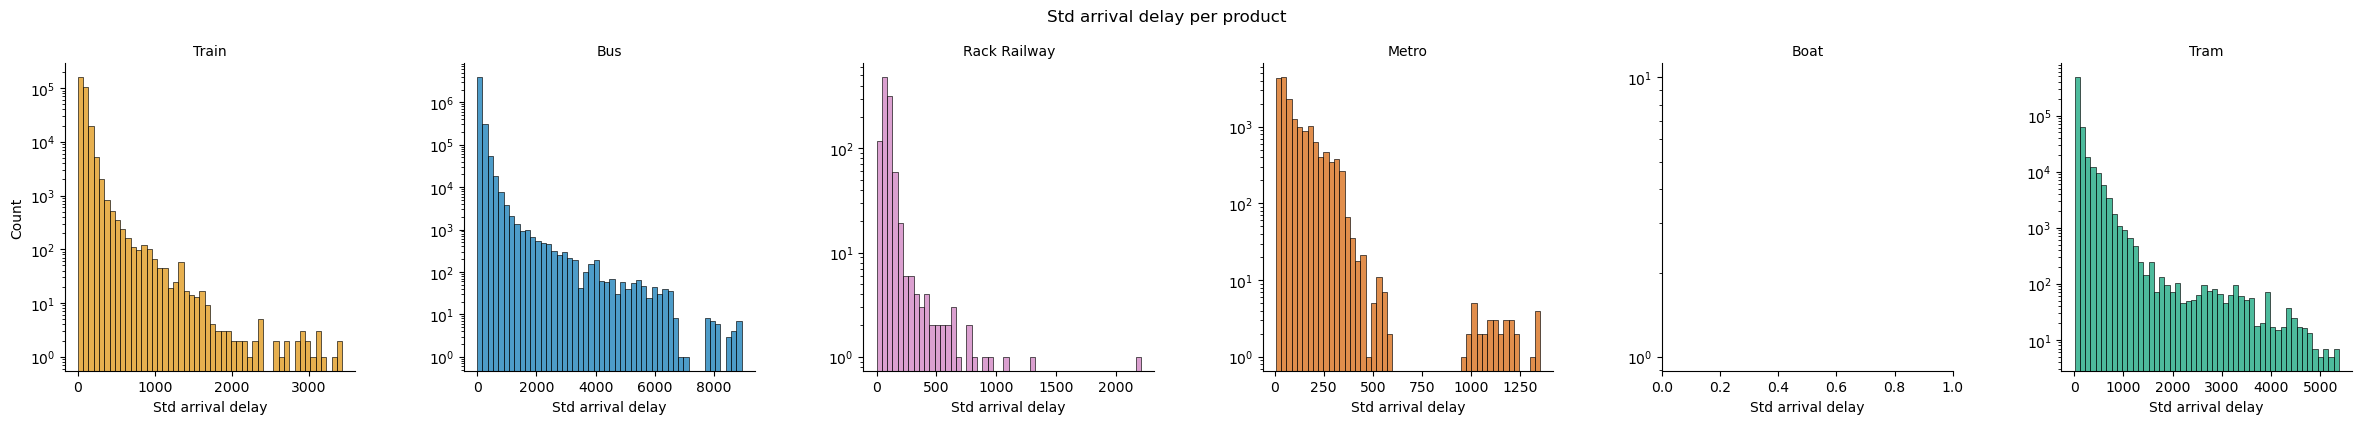

In [22]:
unique_product_ids = transport_data['product_id'].unique()

g = sns.FacetGrid(
    transport_data, 
    col="product_id",
    col_wrap=len(unique_product_ids), 
    hue='product_id', 
    palette=product_to_color,
    height=4, 
    aspect=1,
    sharey=False,
    sharex=False,
)
# Map the histplot function to each subplot
g.map(sns.histplot, "std_arrival_delay", bins=50, alpha=0.7)
g.set(yscale="log")

# Set the titles and labels
g.set_titles("{col_name}")
g.set_axis_labels("Std arrival delay", "Count")
g.fig.suptitle("Std arrival delay per product", y=1.05)

# Show the plot
plt.show()

### **🛫 Departure Delays**

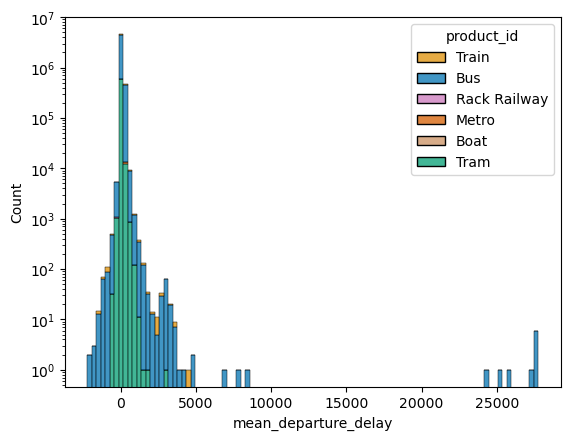

In [23]:
sns.histplot(transport_data, x="mean_departure_delay", hue="product_id", multiple="stack", palette=product_to_color, bins=100)
plt.yscale('log')
plt.show()

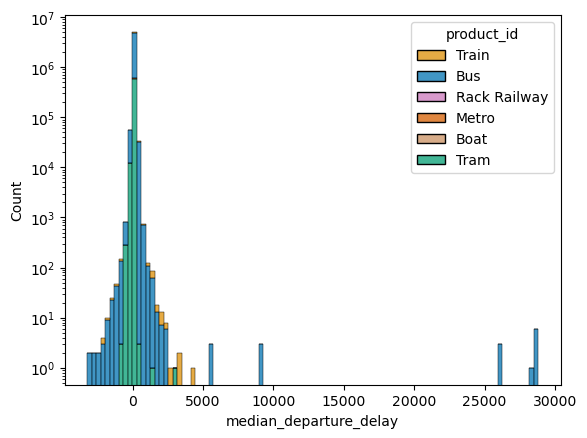

In [24]:
sns.histplot(transport_data, x="median_departure_delay", hue="product_id", multiple="stack", palette=product_to_color, bins=100)
plt.yscale('log')
plt.show()

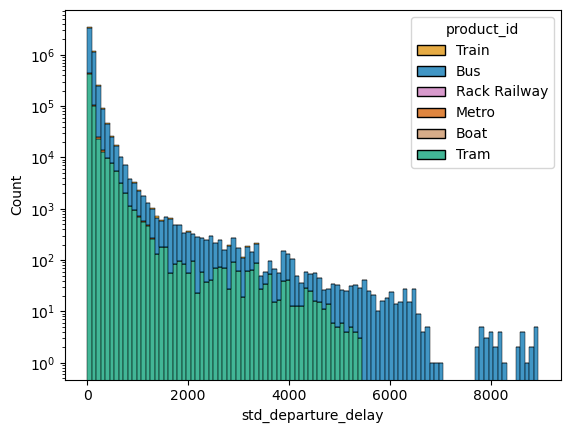

In [25]:
sns.histplot(transport_data, x="std_departure_delay", hue="product_id", multiple="stack", palette=product_to_color, bins=100)
plt.yscale('log')
plt.show()

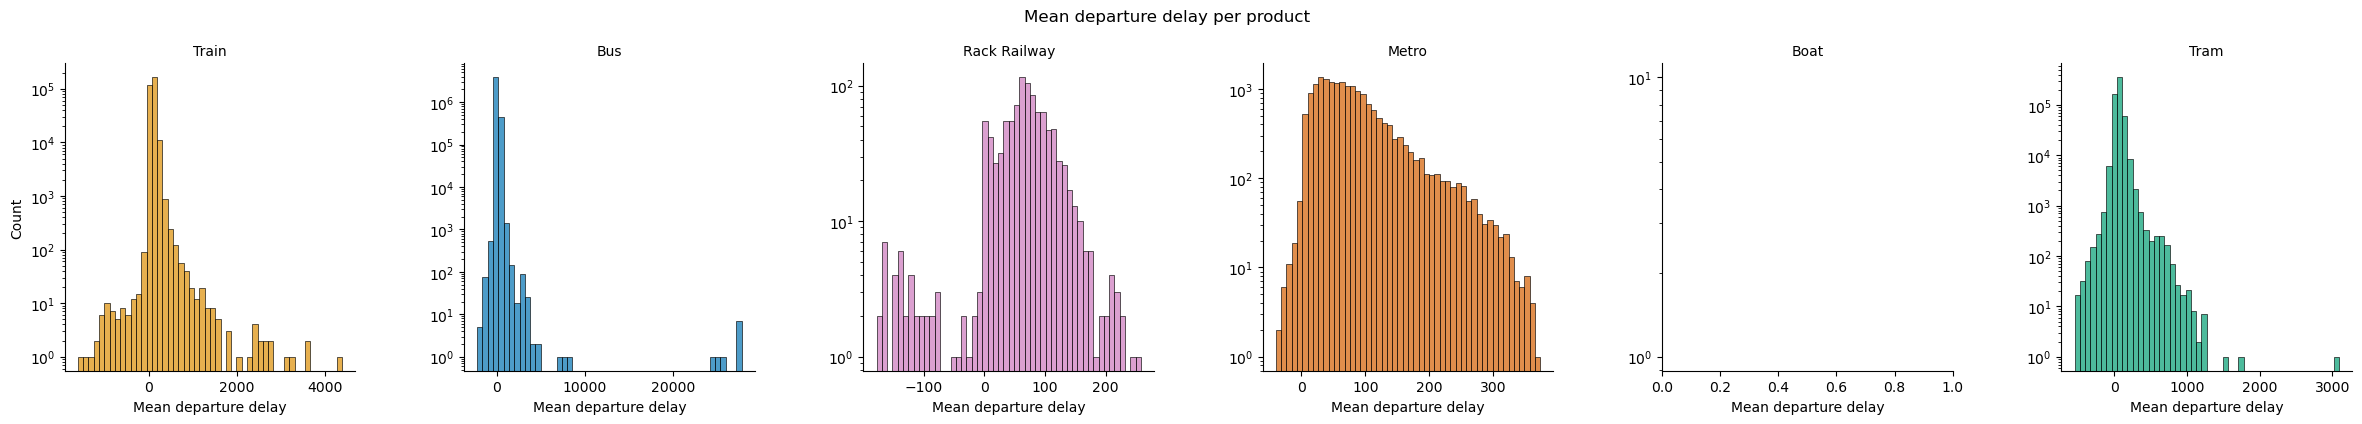

In [26]:
unique_product_ids = transport_data['product_id'].unique()

g = sns.FacetGrid(
    transport_data, 
    col="product_id",
    col_wrap=len(unique_product_ids), 
    hue='product_id', 
    palette=product_to_color,
    height=4, 
    aspect=1,
    sharey=False,
    sharex=False,
)
# Map the histplot function to each subplot
g.map(sns.histplot, "mean_departure_delay", bins=50, alpha=0.7)
g.set(yscale="log")

# Set the titles and labels
g.set_titles("{col_name}")
g.set_axis_labels("Mean departure delay", "Count")
g.fig.suptitle("Mean departure delay per product", y=1.05)

# Show the plot
plt.show()

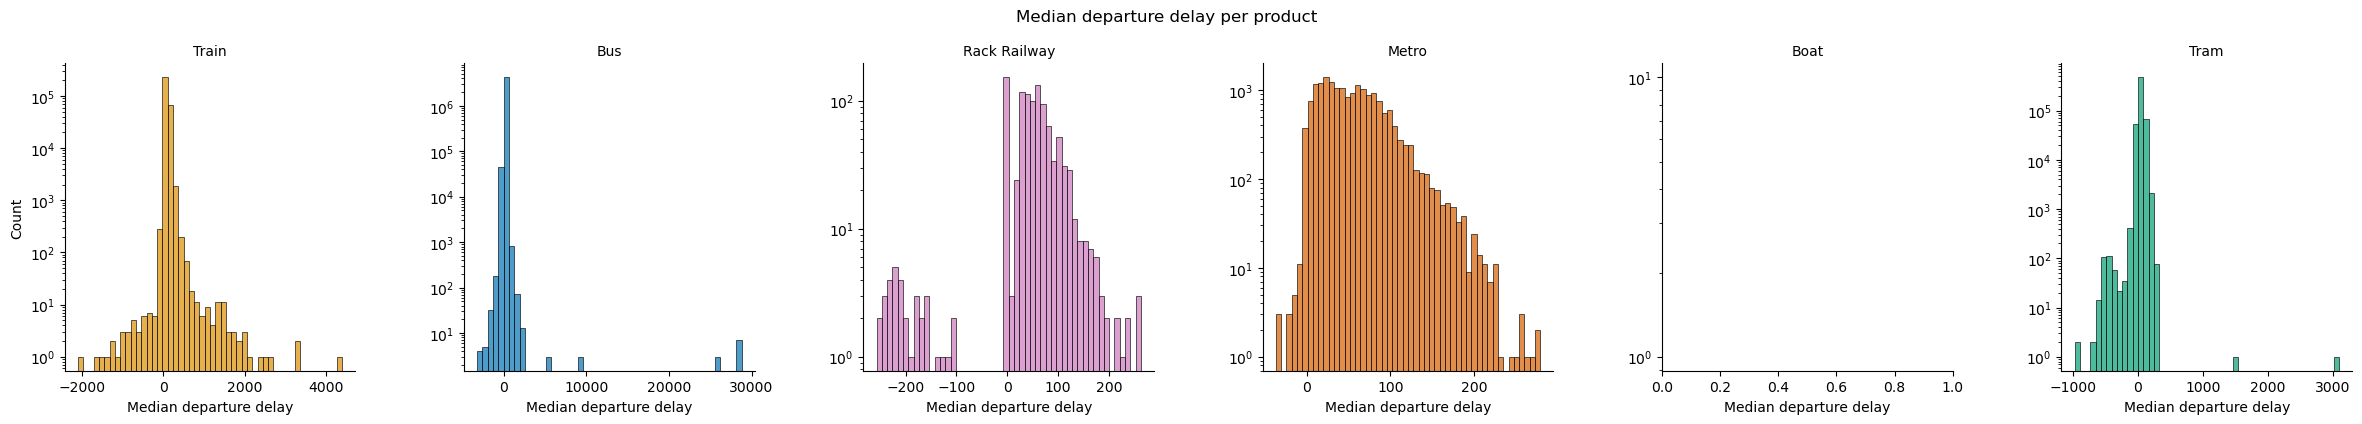

In [27]:
unique_product_ids = transport_data['product_id'].unique()

g = sns.FacetGrid(
    transport_data, 
    col="product_id",
    col_wrap=len(unique_product_ids), 
    hue='product_id', 
    palette=product_to_color,
    height=4, 
    aspect=1,
    sharey=False,
    sharex=False,
)
# Map the histplot function to each subplot
g.map(sns.histplot, "median_departure_delay", bins=50, alpha=0.7)
g.set(yscale="log")

# Set the titles and labels
g.set_titles("{col_name}")
g.set_axis_labels("Median departure delay", "Count")
g.fig.suptitle("Median departure delay per product", y=1.05)

# Show the plot
plt.show()

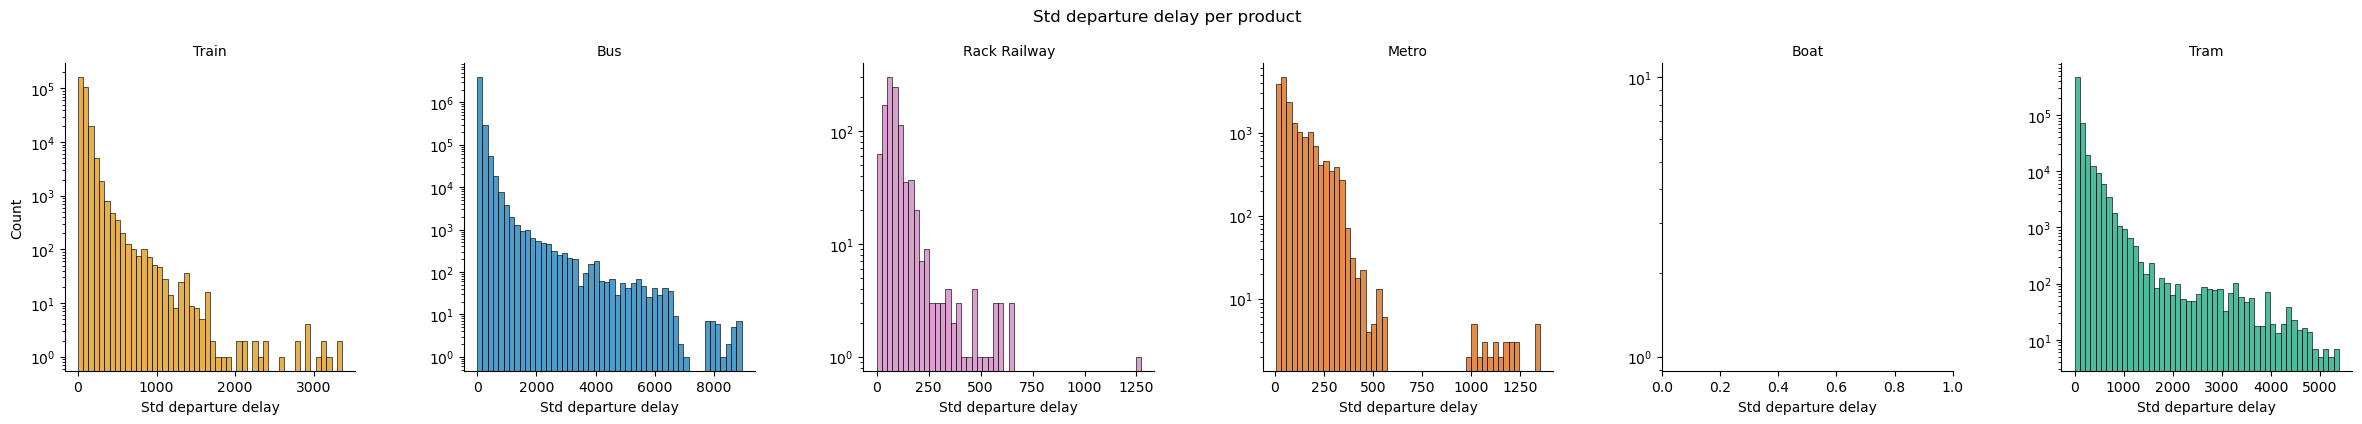

In [28]:
unique_product_ids = transport_data['product_id'].unique()

g = sns.FacetGrid(
    transport_data, 
    col="product_id",
    col_wrap=len(unique_product_ids), 
    hue='product_id', 
    palette=product_to_color,
    height=4, 
    aspect=1,
    sharey=False,
    sharex=False,
)
# Map the histplot function to each subplot
g.map(sns.histplot, "std_departure_delay", bins=50, alpha=0.7)
g.set(yscale="log")

# Set the titles and labels
g.set_titles("{col_name}")
g.set_axis_labels("Std departure delay", "Count")
g.fig.suptitle("Std departure delay per product", y=1.05)

# Show the plot
plt.show()

### **🚆 Transport Types**

In [29]:
products = transport_data[['trip_id', 'product_id']] \
    .drop_duplicates() \
    .groupby('product_id') \
    .count() \
    .rename(columns={'trip_id': 'count'}) \
    .sort_values('count', ascending=False)

products.head()

,count
product_id,
Bus,176167
Tram,19983
Train,16972
Metro,785
Rack Railway,391


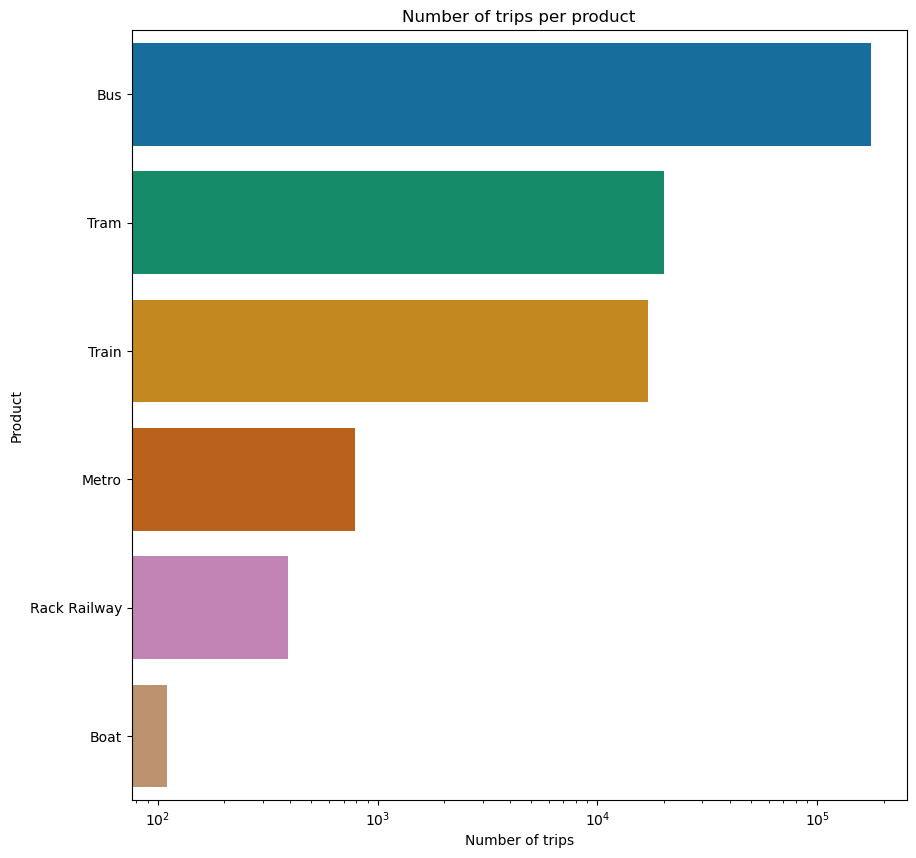

In [30]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.barplot(x='count', 
            y=products.index, 
            data=products, 
            ax=ax, 
            order=products.index, 
            palette=product_to_color
)
ax.set_title('Number of trips per product')
ax.set_xlabel('Number of trips')
ax.set_ylabel('Product')
plt.xscale('log')
plt.show()

In [31]:
transport_types = transport_data[['trip_id', 'transport_type']] \
    .drop_duplicates() \
    .groupby('transport_type') \
    .count() \
    .rename(columns={'trip_id': 'count'}) \
    .sort_values('count', ascending=False)

transport_types.head()

,count
transport_type,
B,175934
T,19983
S,9413
R,3798
RE,1403


In [32]:
transport_types_by_product_id = transport_data[['trip_id', 'transport_type', 'product_id']] \
    .drop_duplicates() \
    .groupby(['transport_type', 'product_id']) \
    .count() \
    .rename(columns={'trip_id': 'count'}) \
    .reset_index() \
    .sort_values('count', ascending=False)
transport_types_by_product_id = transport_types_by_product_id[transport_types_by_product_id['count'] > 0]

# Remove duplicates, the only one is Tram instead of Bus in 1 entry only
transport_types_by_product_id = transport_types_by_product_id[~transport_types_by_product_id.duplicated(subset=['transport_type'], keep='first')]

assert transport_types_by_product_id.set_index('transport_type').index.is_unique

# Merge the products and transport_types_by_product_id dataframes
transport_types_by_product_id = transport_types_by_product_id.merge(
    products.reset_index(), on='product_id', suffixes=('_transport_type', '_product')
)

# Sort the data by product and transport type counts
transport_types_by_product_id = transport_types_by_product_id.sort_values(
    ['count_product', 'count_transport_type'], ascending=[False, False]
)

transport_types_by_product_id.head()

,transport_type,product_id,count_transport_type,count_product
0,B,Bus,175934,176167
1,CAR,Bus,45,176167
2,T,Tram,19983,19983
3,S,Train,9413,16972
4,R,Train,3606,16972


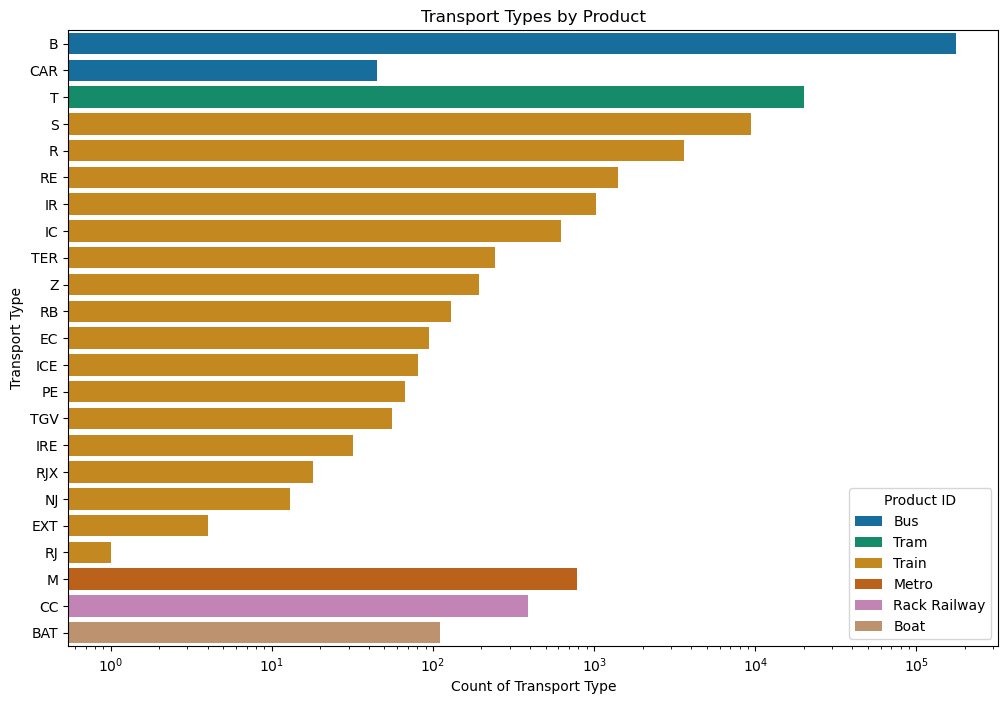

In [33]:
# Create the seaborn horizontal bar plot
plt.figure(figsize=(12, 8))
sns.barplot(
    x='count_transport_type',
    y='transport_type',
    hue='product_id',
    data=transport_types_by_product_id,
    orient='h',
    dodge=False,
    order=transport_types_by_product_id['transport_type'].unique(),
    palette=product_to_color
)

# Customize the plot
plt.xlabel('Count of Transport Type')
plt.ylabel('Transport Type')
plt.title('Transport Types by Product')
plt.legend(title='Product ID', loc='lower right')
plt.xscale('log')

# Display the plot
plt.show()

### **😏 Other Interesting Features**

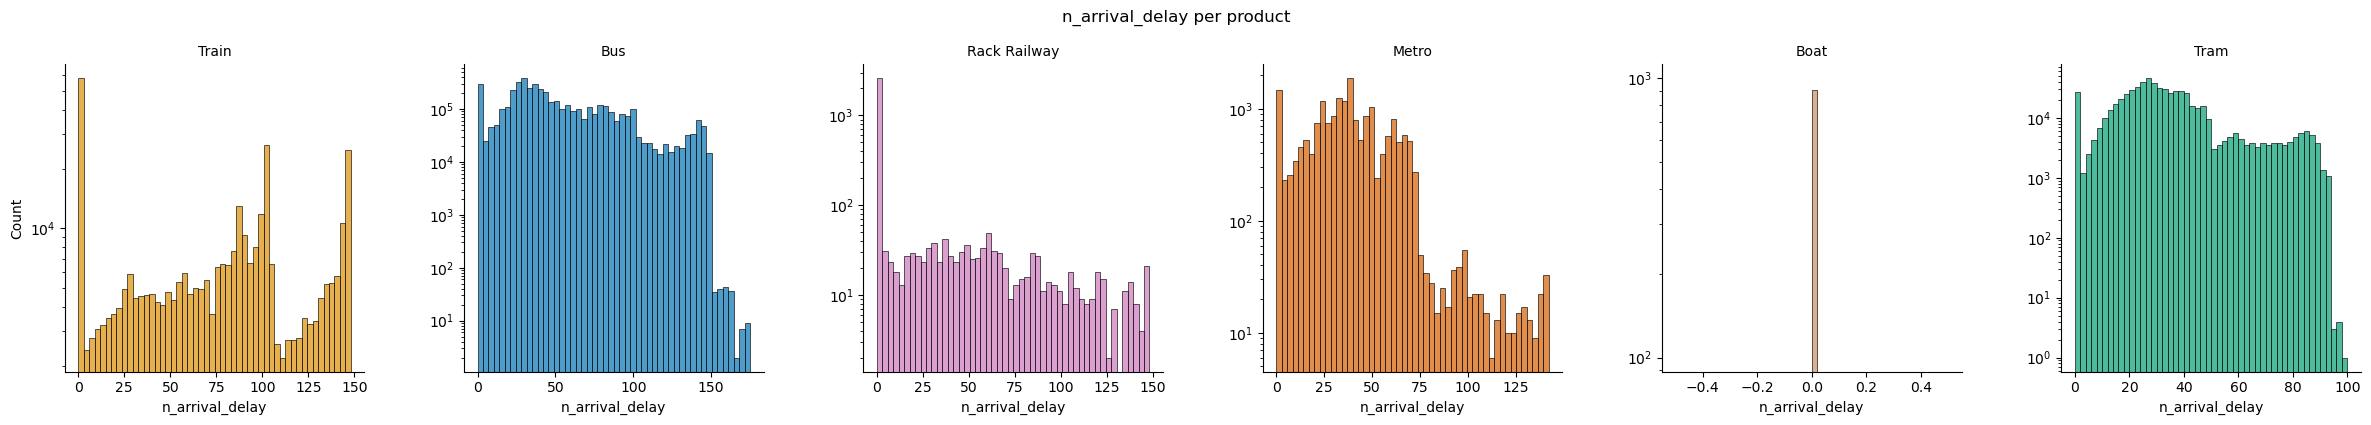

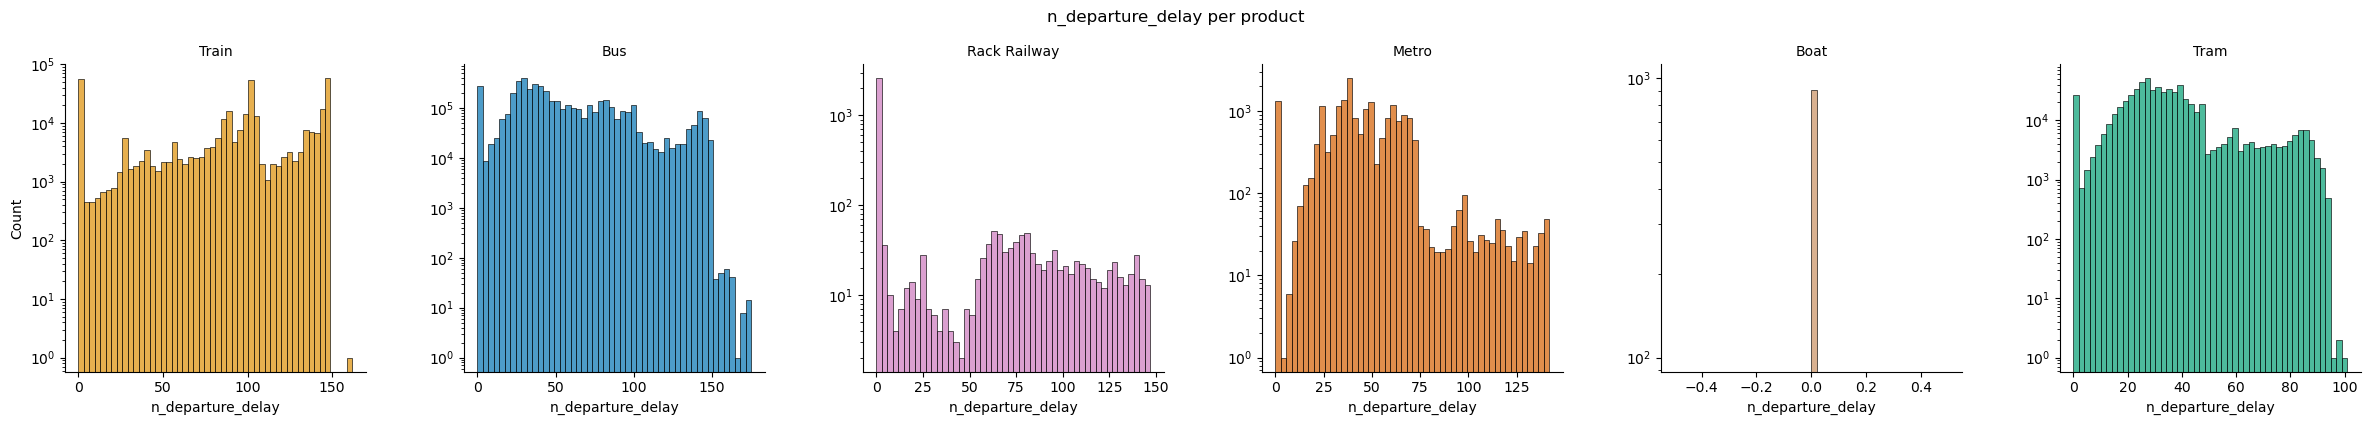

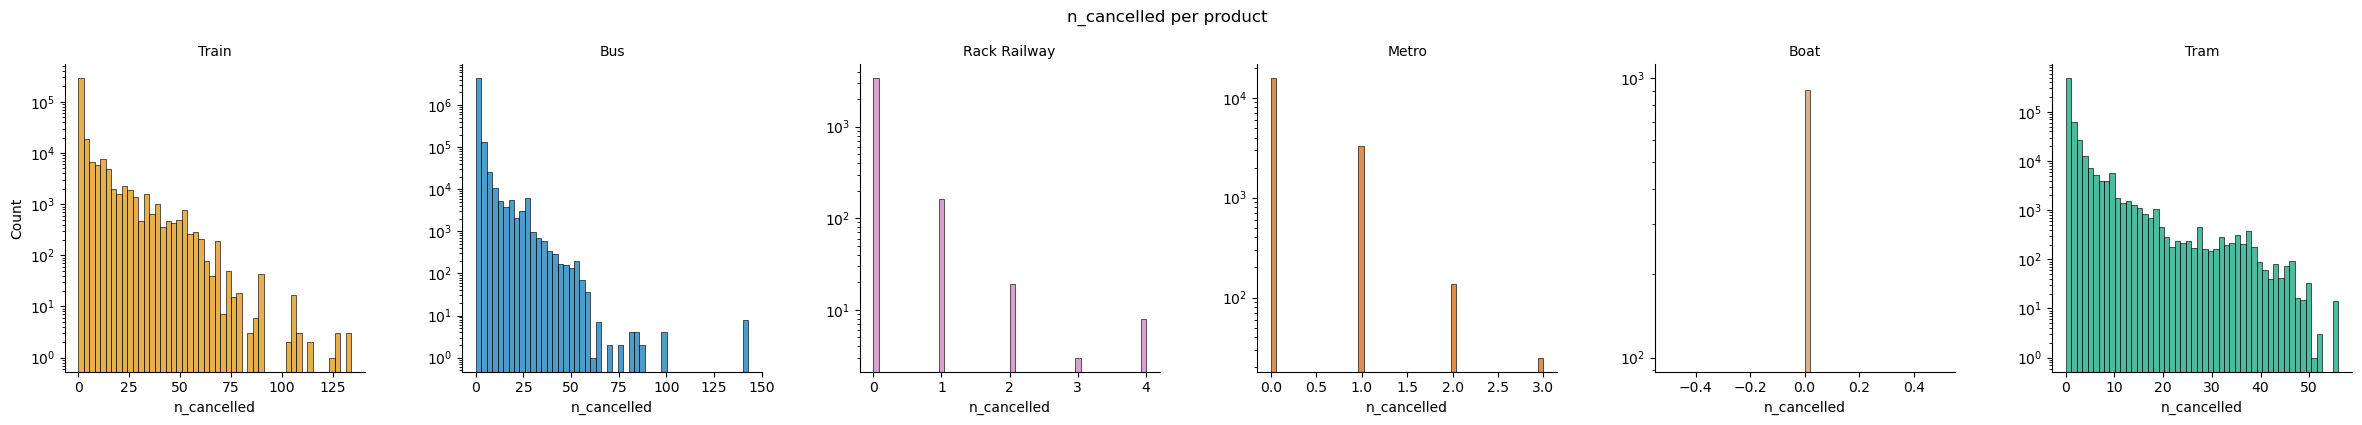

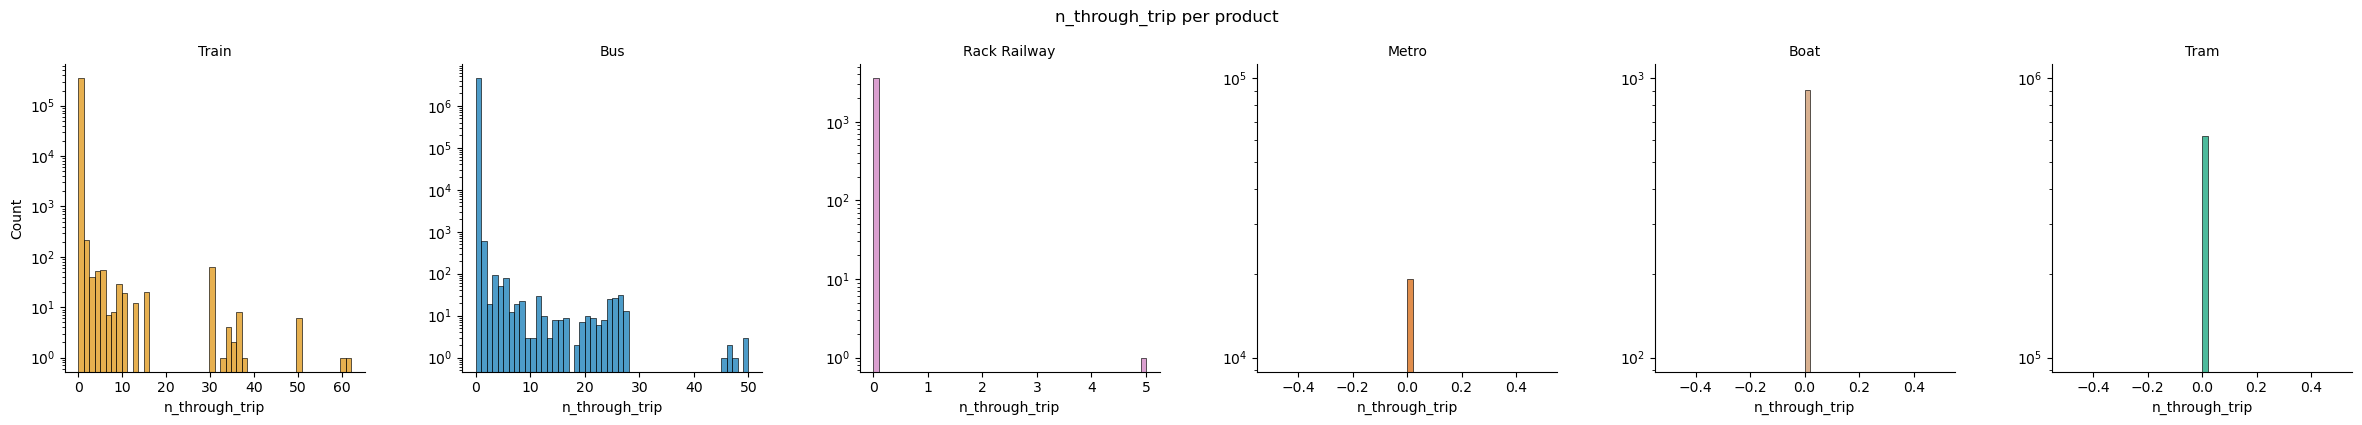

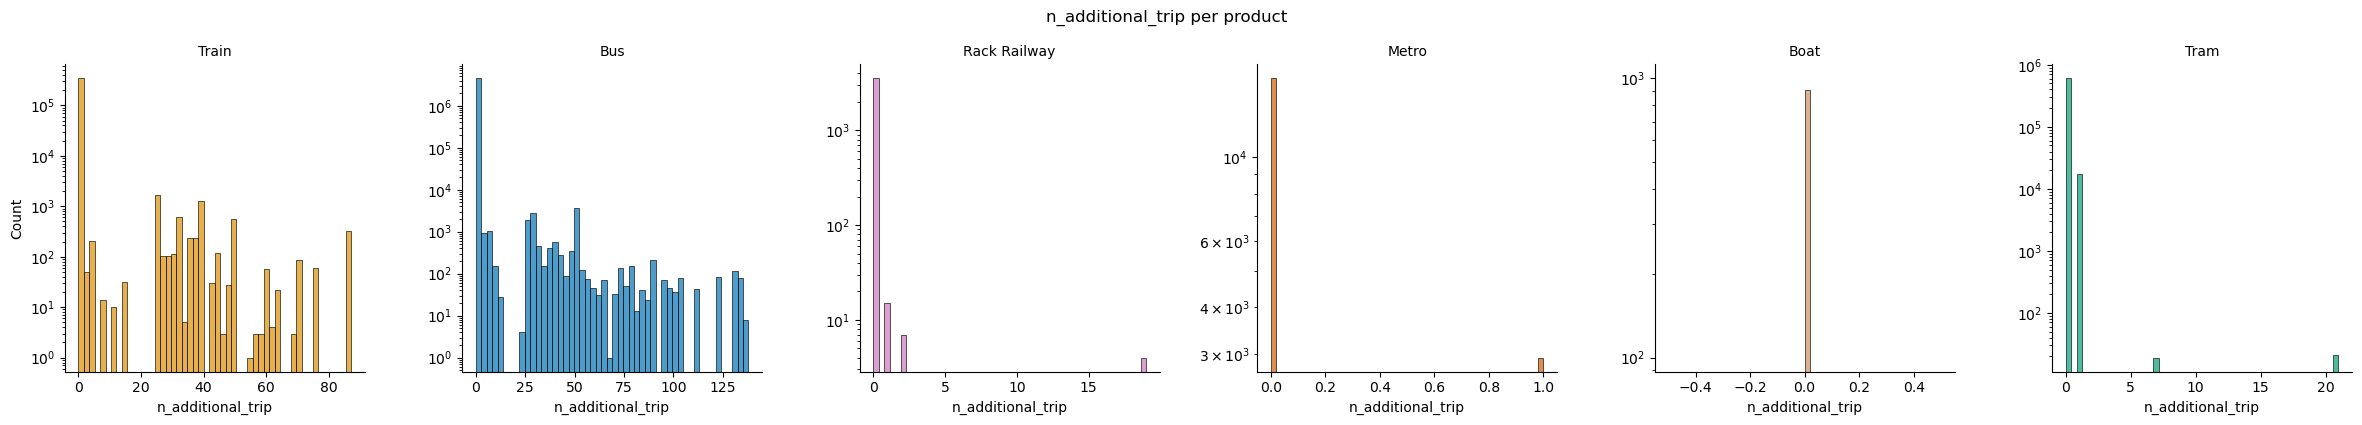

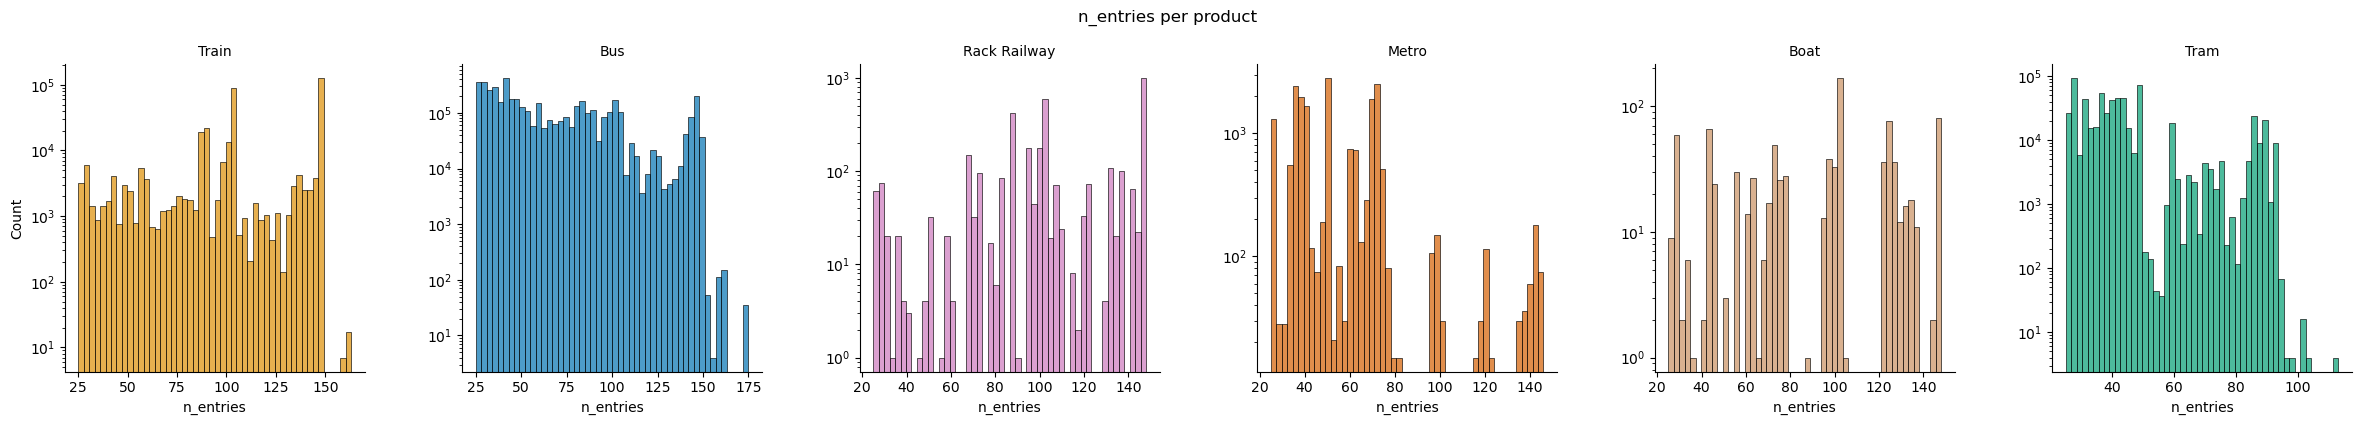

In [34]:
unique_product_ids = transport_data['product_id'].unique()
features = [
    "n_arrival_delay",
    "n_departure_delay",
    "n_cancelled",
    "n_through_trip",
    "n_additional_trip",
    "n_entries",
]

for feature in features:
    g = sns.FacetGrid(
        transport_data,
        col="product_id",
        col_wrap=len(unique_product_ids),
        hue="product_id",
        palette=product_to_color,
        height=4,
        aspect=1,
        sharey=False,
        sharex=False,
    )
    # Map the histplot function to each subplot
    g.map(sns.histplot, feature, bins=50, alpha=0.7)
    g.set(yscale="log")

    # Set the titles and labels
    g.set_titles("{col_name}")
    g.set_axis_labels(f"{feature}", "Count")
    g.fig.suptitle(f"{feature} per product", y=1.05)

    # Show the plot
    plt.show()

In [35]:
transport_data['ratio_cancelled'] = transport_data['n_cancelled'] / transport_data['n_entries']
transport_data['ratio_through_trip'] = transport_data['n_through_trip'] / transport_data['n_entries']
transport_data['ratio_additional_trip'] = transport_data['n_additional_trip'] / transport_data['n_entries']

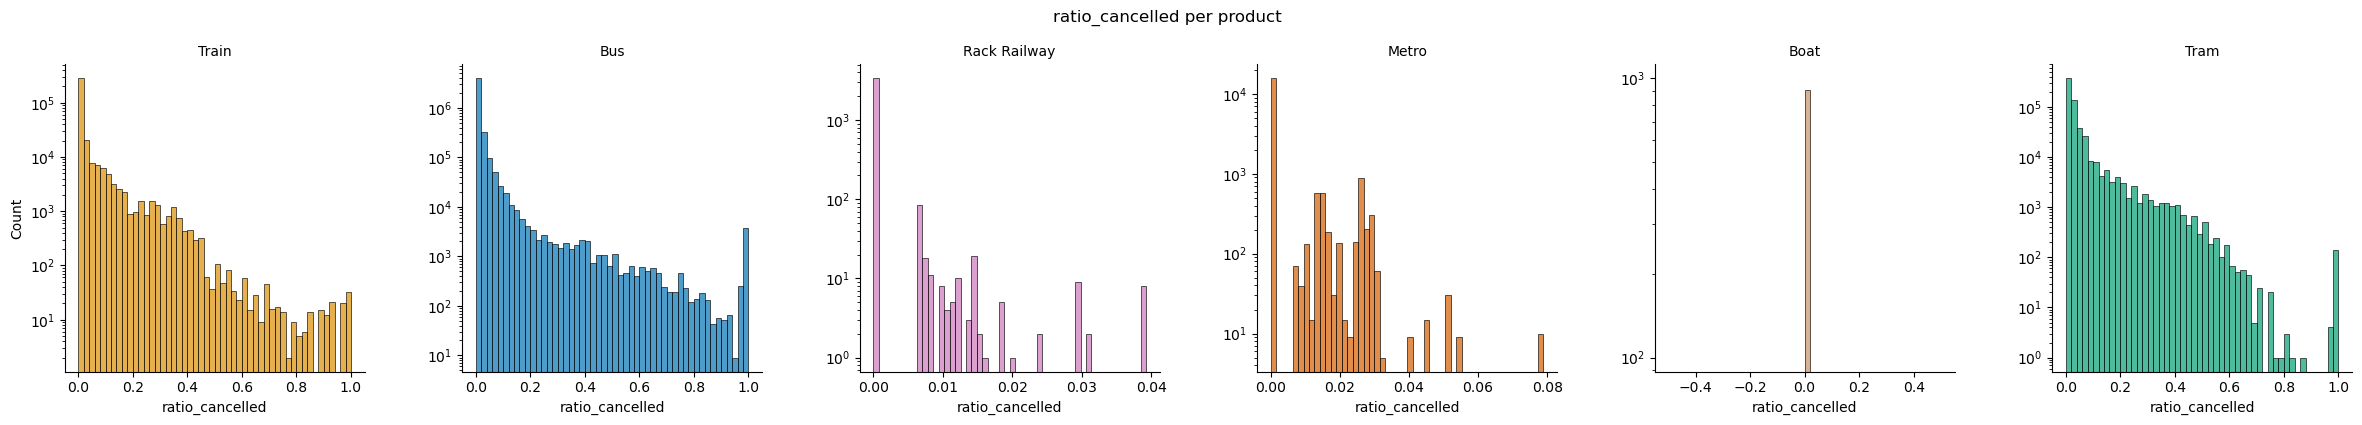

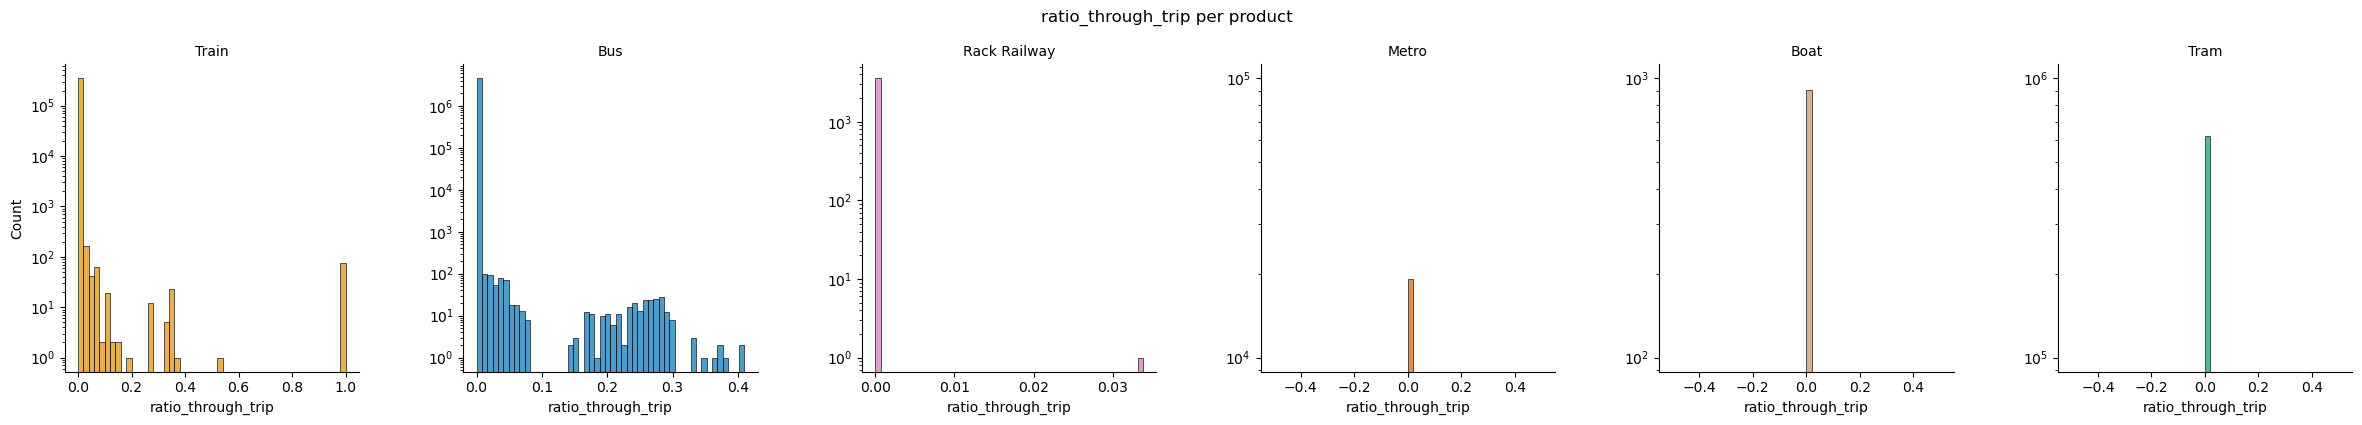

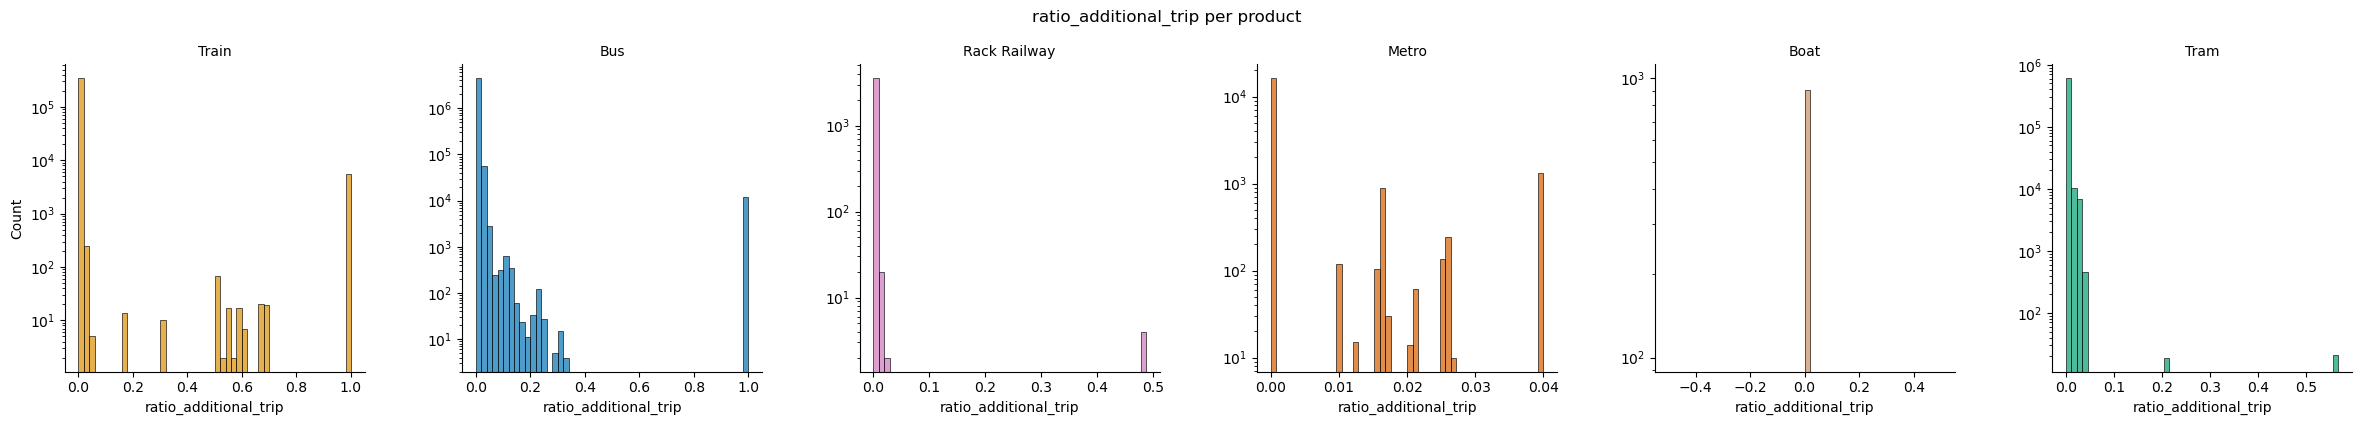

In [36]:
unique_product_ids = transport_data['product_id'].unique()
features = [
    "ratio_cancelled",
    "ratio_through_trip",
    "ratio_additional_trip",
]

for feature in features:
    g = sns.FacetGrid(
        transport_data,
        col="product_id",
        col_wrap=len(unique_product_ids),
        hue="product_id",
        palette=product_to_color,
        height=4,
        aspect=1,
        sharey=False,
        sharex=False,
    )
    # Map the histplot function to each subplot
    g.map(sns.histplot, feature, bins=50, alpha=0.7)
    g.set(yscale="log")

    # Set the titles and labels
    g.set_titles("{col_name}")
    g.set_axis_labels(f"{feature}", "Count")
    g.fig.suptitle(f"{feature} per product", y=1.05)

    # Show the plot
    plt.show()